### Soccer predictions
With the kaggle soccer data set I wanted to make predictions of soccer matches outcomes. The soccer data set contains information about different European leagues with matches, teams and players. I will try to predict the match outcome win, loss or draw. 

The algorithms I am going to use are decision tree, random forest and naive bayes. I will try to compare these algorithms and figure out what has the best result. I am going to use team ratings, previous matches and betting odds for the prediction.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

conn = sqlite3.connect('database.sqlite')

### Example queries
Below are some example queries I did to get used to the data set and working with sqlite3.

##### Countries and leagues
First one query to select all the country's and all the leagues.

In [2]:
c = conn.cursor()

c.execute("SELECT * FROM country")
print(c.fetchall())

print("\n")

c.execute("SELECT * FROM league")
print(c.fetchall())

[(1, 'Belgium'), (1729, 'England'), (4769, 'France'), (7809, 'Germany'), (10257, 'Italy'), (13274, 'Netherlands'), (15722, 'Poland'), (17642, 'Portugal'), (19694, 'Scotland'), (21518, 'Spain'), (24558, 'Switzerland')]


[(1, 1, 'Belgium Jupiler League'), (1729, 1729, 'England Premier League'), (4769, 4769, 'France Ligue 1'), (7809, 7809, 'Germany 1. Bundesliga'), (10257, 10257, 'Italy Serie A'), (13274, 13274, 'Netherlands Eredivisie'), (15722, 15722, 'Poland Ekstraklasa'), (17642, 17642, 'Portugal Liga ZON Sagres'), (19694, 19694, 'Scotland Premier League'), (21518, 21518, 'Spain LIGA BBVA'), (24558, 24558, 'Switzerland Super League')]


##### Matches, players and player attributes
Below examples queries to select one or more rows of the match, player and player attributes tables. As seen below not all fields are filled in in the rows. This is only on some rows.

In [3]:
c.execute("SELECT * FROM match order by ID desc LIMIT 1")
print(c.fetchall())

print("\n")

c.execute("SELECT * FROM player LIMIT 1")
print(c.fetchall())

print("\n")

c.execute("SELECT * FROM player_attributes LIMIT 1")
print(c.fetchall())

[(25979, 24558, 24558, '2015/2016', 9, '2015-09-23 00:00:00', 1992095, 10192, 9931, 4, 3, 1, 2, 4, 6, 8, 2, 4, 6, 8, 4, 6, 1, 2, 4, 6, 8, 4, 6, 3, 5, 7, 5, 1, 3, 3, 3, 3, 7, 7, 7, 7, 10, 10, 1, 3, 3, 3, 3, 6, 6, 8, 8, 8, 11, 274787, 492132, 108451, 25815, 94553, 384376, 598355, 36785, 45174, 302079, 71764, 156175, 95216, 172768, 22834, 458806, 207234, 25772, 40274, 34035, 41726, 527103, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)]


[(1, 505942, 'Aaron Appindangoye', 218353, '1992-02-29 00:00:00', 182.88, 187)]


[(1, 218353, 505942, '2016-02-18 00:00:00', 67, 71, 'right', 'medium', 'medium', 49, 44, 71, 61, 44, 51, 45, 39, 64, 49, 60, 64, 59, 47, 65, 55, 58, 54, 76, 35, 71, 70, 45, 54, 48, 65, 69, 69, 6, 11, 10, 8, 8)]


##### Teams and team attributes
The last tables in the datset are team and team attributes. Below are the example queries I did.

In [4]:
c.execute("SELECT * FROM team LIMIT 1")
print(c.fetchall())

print("\n")

c.execute("SELECT * FROM team_attributes LIMIT 1")
print(c.fetchall())

[(1, 9987, 673, 'KRC Genk', 'GEN')]


[(1, 434, 9930, '2010-02-22 00:00:00', 60, 'Balanced', None, 'Little', 50, 'Mixed', 'Organised', 60, 'Normal', 65, 'Normal', 55, 'Normal', 'Organised', 50, 'Medium', 55, 'Press', 45, 'Normal', 'Cover')]


### Queries for the algorithm
The next step I wanted to take is getting the data that can influence the algorithm like won matches in the past period, total player stats and betting odds. I made the query below to test and find out how I can get the data I need.

In [5]:
c.execute("SELECT match.id, home_team_goal, away_team_goal, season, home_team_goal > away_team_goal " + 
          "FROM team JOIN match ON team.team_api_id = match.home_team_api_id " + 
          "WHERE team.team_long_name = 'KRC Genk' AND season = '2015/2016'")
print(c.fetchall())

[(1491, 3, 1, '2015/2016', 1), (1499, 3, 1, '2015/2016', 1), (1515, 0, 4, '2015/2016', 0), (1530, 0, 2, '2015/2016', 0), (1554, 0, 1, '2015/2016', 0), (1563, 0, 0, '2015/2016', 0), (1587, 3, 0, '2015/2016', 1), (1603, 2, 1, '2015/2016', 1), (1619, 1, 0, '2015/2016', 1), (1635, 6, 1, '2015/2016', 1), (1651, 3, 2, '2015/2016', 1), (1674, 4, 1, '2015/2016', 1), (1685, 2, 1, '2015/2016', 1), (1698, 2, 0, '2015/2016', 1), (1715, 3, 1, '2015/2016', 1)]


### Converting to dataframes
Because I like pandas better than SQL I wanted to change the tables into pandas dataframes.

In [6]:
teams = pd.read_sql("SELECT * FROM team", conn)
matches = pd.read_sql("SELECT * FROM match", conn)
players = pd.read_sql("SELECT * FROM player", conn)
players_stats = pd.read_sql("SELECT * FROM player_attributes", conn)

### Functions
Because of the hard quering I wanted to make some functions to easily get the things I want in the algorithm. 

##### Rating function
First I will make a function to get the rating of the home and away team of a match. The rating is based on player stats.

In [7]:
def get_rating_home(match):  
    rating = 0
    
    for i in range(1,12):   
        player_id = match['home_player_' + str(i)]
        player = players_stats[players_stats['player_api_id'] == player_id]
        if(not player.empty):
            rating += player['overall_rating'].values[0]
    return rating    

def get_rating_away(match):  
    rating = 0
    
    for i in range(1,12):   
        player_id = match['away_player_' + str(i)]
        player = players_stats[players_stats['player_api_id'] == player_id]
        if(not player.empty):
            rating += player['overall_rating'].values[0]
    return rating    

In [8]:
print("Rating home team: " + str(get_rating_home(matches[matches['id'] == 1715].iloc[0])))
print("Rating away team: " + str(get_rating_away(matches[matches['id'] == 1715].iloc[0])))

Rating home team: 787.0
Rating away team: 760.0


##### Last number of results function
The next function I will create is the last number of results of a team. A date can be passed to the function to get the last number of matches before that specific date.

In [9]:
def get_last_x_results(team, x, date = None):
    results = {
        "wins": 0,
        "losses": 0,
        "draws": 0
    }  
    
    team_api_id = team['team_api_id'].values[0]
    
    tempMatches = matches
    if(date is not None):
        tempMatches = tempMatches[tempMatches['date'] < date]
    
    sorted_matches = tempMatches.sort_values(['date'], ascending=False)
    last_x_matches = sorted_matches[(sorted_matches['home_team_api_id'] == team_api_id) | 
                                    (sorted_matches['away_team_api_id'] == team_api_id)].head(x)
    
    for index, match in last_x_matches.iterrows():
        if(match["home_team_api_id"] == team_api_id):
            if(match["home_team_goal"] > match["away_team_goal"]): results["wins"] += 1 
            elif(match["home_team_goal"] < match["away_team_goal"]): results["losses"] += 1
            else: results["draws"] += 1
        else:
            if(match["away_team_goal"] > match["home_team_goal"]): results["wins"] += 1
            elif(match["away_team_goal"] < match["home_team_goal"]): results["losses"] += 1
            else: results["draws"] += 1
    
    return results   

In [10]:
print("KRC Genk laatste 10: " + str(get_last_x_results(teams[teams['id'] == 1], 10)))
print("PSV laatste 5: " + str(get_last_x_results(teams[teams['id'] == 26556], 5)))
print("PSV laatste 5 voor 12 juni 2016: " + str(get_last_x_results(teams[teams['id'] == 26556], 5, '2014-08-20')))

KRC Genk laatste 10: {'wins': 6, 'losses': 2, 'draws': 2}
PSV laatste 5: {'wins': 5, 'losses': 0, 'draws': 0}
PSV laatste 5 voor 12 juni 2016: {'wins': 4, 'losses': 1, 'draws': 0}


##### Last number of results against team function
Another imporant factor of winning the match is the previous results against a team. The following function will return the results of a team against another team. With this function a date can be passed to get the last number of matches before this date.

In [11]:
def get_last_x_results_against_team(team, team2, x, date = None):
    results = {
        "wins": 0,
        "losses": 0,
        "draws": 0
    }
    
    team_api_id = team['team_api_id'].values[0]
    team2_api_id = team2['team_api_id'].values[0]
    
    tempMatches = matches
    if(date is not None):
        tempMatches = tempMatches[tempMatches['date'] < date]
    
    sorted_matches = tempMatches.sort_values(['date'], ascending=False)
    last_x_matches = sorted_matches[(sorted_matches['home_team_api_id'] == team_api_id) & 
                                    (sorted_matches['away_team_api_id'] == team2_api_id) |
                                    (sorted_matches['home_team_api_id'] == team2_api_id) &
                                    (sorted_matches['away_team_api_id'] == team_api_id)].head(x)
    
    for index, match in last_x_matches.iterrows():
        if(match["home_team_api_id"] == team_api_id):
            if(match["home_team_goal"] > match["away_team_goal"]): results["wins"] += 1 
            elif(match["home_team_goal"] < match["away_team_goal"]): results["losses"] += 1
            else: results["draws"] += 1
        else:
            if(match["away_team_goal"] > match["home_team_goal"]): results["wins"] += 1
            elif(match["away_team_goal"] < match["home_team_goal"]): results["losses"] += 1
            else: results["draws"] += 1

    return results 

In [12]:
teams[teams['team_long_name'].str.contains("Anderlecht")]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
5,6,8635,229.0,RSC Anderlecht,AND


In [13]:
teams[teams['team_long_name'] == 'Ajax']

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
161,26552,8593,245.0,Ajax,AJA


In [14]:
print("KRC Genk tegen Anderlecht laatste 2: " + str(get_last_x_results_against_team(teams[teams['id'] == 1], teams[teams['id'] == 6], 2)))
print("PSV tegen Ajax laatste 3: " + str(get_last_x_results_against_team(teams[teams['id'] == 26556], teams[teams['id'] == 26552], 3)))
print("PSV tegen Ajax laatste 3 voor 2012-08-20: " + str(get_last_x_results_against_team(teams[teams['id'] == 26556], teams[teams['id'] == 26552], 3, '2012-08-20')))

KRC Genk tegen Anderlecht laatste 2: {'wins': 0, 'losses': 0, 'draws': 2}
PSV tegen Ajax laatste 3: {'wins': 1, 'losses': 2, 'draws': 0}
PSV tegen Ajax laatste 3 voor 2012-08-20: {'wins': 0, 'losses': 1, 'draws': 2}


##### Betting odds function
The betting odds can be an influence on the match. It already has some kind of prediction and chances. I am not sure if I want to use this in the algorithm.

In [15]:
def get_betting_odds(match):  
    betting_odds = []

    betting_providers = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
    for provider in betting_providers:
        home = match[provider + 'H']
        draw = match[provider + 'D']
        away = match[provider + 'A']
        betting_odds.append([provider, home, draw, away])
    
    return betting_odds   

In [16]:
print("Betting odds: " + str(get_betting_odds(matches.loc[matches['id'] == 1715].iloc[0])))

Betting odds: [['B365', 1.83, 3.6, 4.2], ['BW', 1.78, 3.6, 4.4], ['IW', 1.8, 3.5, 4.2], ['LB', 1.85, 3.5, 4.2], ['PS', 1.88, 3.78, 4.39], ['WH', 1.83, 3.4, 4.0], ['SJ', nan, nan, nan], ['VC', 1.8, 3.7, 4.2], ['GB', nan, nan, nan], ['BS', nan, nan, nan]]


##### Match result function
The last function is the match result. It looks at the home and away goals and returns the match result of the home team. 2 is a win, 1 a loss and 0 a draw.

In [17]:
def get_match_result(match):  
    if(match["home_team_goal"] > match["away_team_goal"]): return 2
    elif(match["home_team_goal"] < match["away_team_goal"]): return 1
    else: return 0

In [18]:
print("Match result: " + str(get_match_result(matches[matches['id'] == 1715].iloc[0])))

Match result: 2


### Creating the data
The next step is to create the data. I will take 5000 rows of matches because the more I take the slower it gets. The function below loops through this matches and gets all the data I think I need for predicting the matches. This will be put into a new data frame called matches_custom.

In [19]:
matches_custom = pd.DataFrame(columns=['home_team','away_team','previous_matches_home_wins','previous_matches_home_draws',
                                       'previous_matches_home_losses','previous_matches_away_wins','previous_matches_away_draws',
                                       'previous_matches_away_losses','previous_encounters_home_win','previous_encounters_home_draws',
                                       'previous_encounters_home_losses','betting_odds','rating_home','rating_away','result'])

for index, match in matches.tail(5000).iterrows():
    last_results_home = get_last_x_results(teams[teams['team_api_id'] == match["home_team_api_id"]], 10, match['date'])
    last_results_away = get_last_x_results(teams[teams['team_api_id'] == match["away_team_api_id"]], 10, match['date'])
    last_results_against_other = get_last_x_results_against_team(teams[teams['team_api_id'] == match["home_team_api_id"]], 
                                                      teams[teams['team_api_id'] == match["away_team_api_id"]], 3, match['date'])
    
    matches_custom.loc[index] = [match["home_team_api_id"], 
                      match["away_team_api_id"], last_results_home["wins"],last_results_home["draws"],last_results_home["losses"],
                      last_results_away["wins"],last_results_away["draws"],last_results_away["losses"],
                      last_results_against_other['wins'],last_results_against_other['draws'],last_results_against_other['losses'],
                      get_betting_odds(match),get_rating_home(match),get_rating_away(match),get_match_result(match)]

matches_custom.head()

,home_team,away_team,previous_matches_home_wins,previous_matches_home_draws,previous_matches_home_losses,previous_matches_away_wins,previous_matches_away_draws,previous_matches_away_losses,previous_encounters_home_win,previous_encounters_home_draws,previous_encounters_home_losses,betting_odds,rating_home,rating_away,result
20979,8597,9860,2,3,5,2,3,5,2,0,1,"[[B365, 1.8, 3.6, 4.33], [BW, 1.65, 3.8, 4.25]...",699.0,696.0,2
20980,8426,9925,2,5,3,9,0,1,0,0,2,"[[B365, 9.0, 5.0, 1.33], [BW, 8.0, 5.25, 1.28]...",688.0,794.0,1
20981,8649,8485,3,3,4,7,1,2,2,0,1,"[[B365, 4.5, 3.8, 1.73], [BW, 3.6, 3.5, 1.85],...",682.0,734.0,0
20982,9800,8467,2,1,7,5,1,4,1,0,2,"[[B365, 2.9, 3.1, 2.5], [BW, 2.7, 3.1, 2.45], ...",703.0,706.0,1
20983,8485,9938,6,2,2,6,2,2,2,0,1,"[[B365, 2.05, 3.4, 3.5], [BW, 2.0, 3.3, 3.4], ...",732.0,708.0,0


In [20]:
matches_custom.tail()

,home_team,away_team,previous_matches_home_wins,previous_matches_home_draws,previous_matches_home_losses,previous_matches_away_wins,previous_matches_away_draws,previous_matches_away_losses,previous_encounters_home_win,previous_encounters_home_draws,previous_encounters_home_losses,betting_odds,rating_home,rating_away,result
25974,10190,10191,3,1,6,2,2,6,2,0,1,"[[B365, nan, nan, nan], [BW, nan, nan, nan], [...",682.0,680.0,2
25975,9824,10199,1,3,6,4,3,3,0,1,2,"[[B365, nan, nan, nan], [BW, nan, nan, nan], [...",666.0,715.0,1
25976,9956,10179,6,2,2,5,2,3,1,2,0,"[[B365, nan, nan, nan], [BW, nan, nan, nan], [...",747.0,749.0,2
25977,7896,10243,2,0,6,3,3,4,0,0,0,"[[B365, nan, nan, nan], [BW, nan, nan, nan], [...",607.0,714.0,0
25978,10192,9931,4,3,3,9,1,0,1,1,1,"[[B365, nan, nan, nan], [BW, nan, nan, nan], [...",771.0,803.0,2


### Exploring the data
Next I will plot the some graphs of the data to explore the data and get interesting insights.

##### Match results home

Counter({2: 2364, 1: 1469, 0: 1167})


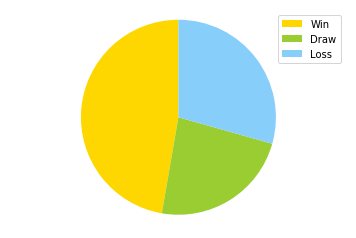

In [21]:
from collections import Counter

results = Counter(matches_custom['result'])

print(results)

# Data to plot
labels = results
labels['Win'] = labels.pop(2)
labels['Draw'] = labels.pop(0)
labels['Loss'] = labels.pop(1)

sizes = results.values()
colors = ['gold', 'yellowgreen', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.show()

With above pie chart we can make the conclusion that the most home matches results in a win. 2 is a win for the home team, 1 is a lose for the home team and 0 is a draw.

##### Match results with previous encounter wins

previous_encounters_home_win  result
0                             2         869
                              1         759
                              0         508
1                             2         761
                              1         496
                              0         395
2                             2         532
                              0         213
                              1         178
3                             2         202
                              0          51
                              1          36
Name: result, dtype: int64


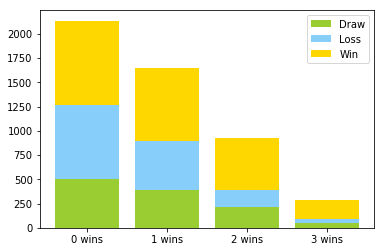

In [22]:
df = matches_custom.groupby('previous_encounters_home_win')['result'].value_counts()

print(df)

fig, ax = plt.subplots()
p1 = plt.bar(['0 wins','1 wins','2 wins','3 wins'], df.loc[:,0].values, color='yellowgreen')
p2 = plt.bar(['0 wins','1 wins','2 wins','3 wins'], df.loc[:,1].values, bottom=df.loc[:,0].values, color='lightskyblue')
p3 = plt.bar(['0 wins','1 wins','2 wins','3 wins'], df.loc[:,2].values, bottom=df.loc[:,0].values+df.loc[:,1].values, color='gold')

ax.legend((p1[0], p2[0], p3[0]), ('Draw', 'Loss', 'Win'))
plt.show()

 Above bar chart shows on the x axis the number of previous wins against the other team the match is. The green part shows the outcome as wins, the orange is the outcome as losses and the blue part is the outcome as draws.

In [23]:
df = matches_custom[matches_custom['previous_encounters_home_win'] + matches_custom['previous_encounters_home_draws'] + matches_custom['previous_encounters_home_losses'] == 0]
print(df.shape[0])

df = matches_custom[matches_custom['previous_matches_away_wins'] + matches_custom['previous_matches_away_draws'] + matches_custom['previous_matches_away_losses'] == 0]
print(df.shape[0])

df = matches_custom[matches_custom['previous_matches_home_wins'] + matches_custom['previous_matches_home_draws'] + matches_custom['previous_matches_home_losses'] == 0]
print(df.shape[0])

551
23
25


The problem with this is that not all matches have previous encounter this can be because the club promoted or that it is the begin of the dataset and has no matches before.

previous_encounters_home_win  result
0                             2         618
                              1         595
                              0         372
1                             2         761
                              1         496
                              0         395
2                             2         532
                              0         213
                              1         178
3                             2         202
                              0          51
                              1          36
Name: result, dtype: int64


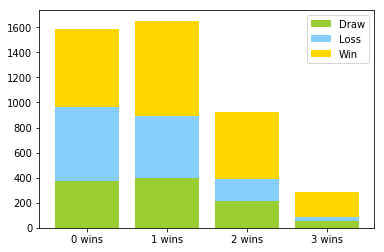

In [24]:

df = matches_custom[matches_custom['previous_encounters_home_win'] + matches_custom['previous_encounters_home_draws'] + matches_custom['previous_encounters_home_losses'] != 0]
df = df.groupby('previous_encounters_home_win')['result'].value_counts()

print(df)

fig, ax = plt.subplots()
p1 = plt.bar(['0 wins','1 wins','2 wins','3 wins'], df.loc[:,0].values, color='yellowgreen')
p2 = plt.bar(['0 wins','1 wins','2 wins','3 wins'], df.loc[:,1].values, bottom=df.loc[:,0].values, color='lightskyblue')
p3 = plt.bar(['0 wins','1 wins','2 wins','3 wins'], df.loc[:,2].values, bottom=df.loc[:,0].values+df.loc[:,1].values, color='gold')

ax.legend((p1[0], p2[0], p3[0]), ('Draw', 'Loss', 'Win'))
plt.show()

Above the values without previous matches against each other are filtered out. The losses part is now a little bit higher then the win part with 0 wins in previous matches.

### Metrics
I choose to use the **accuracy** metric for my algorithm. This is because I want to predict the match as correctly as possible. It is not really interesting to calculate the True positives and False postives or True positives and False postives.

### Decision Tree
The first algorithm I wanted to try out is decision tree. This algorithm will create a tree and tries to predict if the match outcome is a win, loss or draw. A tree has the risk of overfitting this is something I need to look out for.

In [25]:
matches_X = matches_custom[['rating_home','rating_away']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

X_train.shape, y_train.shape

((3750, 2), (3750,))

In [27]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 4)
clf = clf.fit(X_train, y_train)

In [28]:
from sklearn import metrics

y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.518


The accuracy is little more then 51%. This is a good result at first. What I wanted to know is if the algorithm did also calculate draws. 

In [29]:
print(clf.feature_importances_)

[0.46614463 0.53385537]


In [30]:
np.unique(y_pred)

array([1, 2])

As seen above the predicted values did not contain draws. The Tree could be not large enough or the test data did not have a optional draw. An interesting thing to do is see what the tree really does.

In [31]:
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

graph[0].write_pdf("tree.pdf")

In [32]:
clf = tree.DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5)
np.average(scores)

0.5309404833312297

The cross validation score is 53% which is a little bit heigher then the 51% for the test set.

Next thing I want to add is the other variables like previous matches from the home and away team and the previous encounters.

In [33]:
matches_X = matches_custom[['rating_home','rating_away','previous_matches_home_wins',
                            'previous_matches_home_draws','previous_matches_home_losses','previous_matches_away_wins',
                            'previous_matches_away_draws','previous_matches_away_losses','previous_encounters_home_win',
                            'previous_encounters_home_draws','previous_encounters_home_losses']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

X_train.shape, y_train.shape

((3750, 11), (3750,))

In [35]:
clf = tree.DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 6)
clf = clf.fit(X_train, y_train)
print(clf.feature_importances_)

[0.45575053 0.50556506 0.00930769 0.         0.         0.02309619
 0.         0.         0.         0.         0.00628052]


In [36]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.513


In [37]:
clf = tree.DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 8)

scores = cross_val_score(clf, X_train, y_train, cv=5)
np.average(scores)

0.5226663409771988

In [38]:
np.unique(y_pred)

array([1, 2])

As seen above the tree only uses the team ratings and the previous matches home wins and previous matches away wins and last the previous encounters home losses. The accuracy is a little lower then the previous one without the other data but still around 51% for the test set and 52% as cross validation score which is a little bit lower then with only the ratings.

Next I wanted to try to make the depth more and try to let all the variables influence the outcome.

In [39]:
clf = tree.DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 5)
clf = clf.fit(X_train, y_train)
print(clf.feature_importances_)

[0.36356822 0.43842266 0.02961421 0.02795564 0.01835511 0.04152697
 0.00684905 0.02741572 0.0042843  0.01811764 0.02389047]


In [40]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.486


In [41]:
np.unique(y_pred)

array([0, 1, 2])

The algorithm does now predict draws and the outcome is worse the accuracy is now around 48%. Next I want to use parameter tuning to get the best parameters for the algorithm.

##### Grid search parameter tuning
The parameters I will tune are min samples leaf and the max depth

In [42]:
tuned_parameters = [{'min_samples_leaf': range(1, 20), 'max_depth': range(1, 20)}]

In [43]:
matches_X = matches_custom[['rating_home','rating_away','previous_matches_home_wins',
                            'previous_matches_home_draws','previous_matches_home_losses','previous_matches_away_wins',
                            'previous_matches_away_draws','previous_matches_away_losses','previous_encounters_home_win',
                            'previous_encounters_home_draws','previous_encounters_home_losses']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [44]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.best_params_)

{'max_depth': 4, 'min_samples_leaf': 6}


In [45]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.513


In [46]:
clf = tree.DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 6)

scores = cross_val_score(clf, X_train, y_train, cv=5)
decision_tree_all_param_score = np.average(scores)
decision_tree_all_param_score

0.5242706123921999

The advised depth is 4 and the min samples leaf 6. With this algorithm I get again a 51% accuracy on the test set and 52% cross validation score. Next I want to look wat the Grid search suggests without the previous matches variables.

In [47]:
matches_X = matches_custom[['rating_home','rating_away']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [48]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.best_params_)

{'max_depth': 6, 'min_samples_leaf': 1}


In [49]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.503


In [50]:
clf = tree.DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 1)

scores = cross_val_score(clf, X_train, y_train, cv=5)
decision_tree_rating_param_score = np.average(scores)
decision_tree_rating_param_score

0.5320035982286191

With this data the advised depth is 6 and min samples leaf 1. The outcome is worse with this test set and the cross validation score is higher than with the other variables.

#### Overfitting
Next I will try to show when my algorith gets overfitted.

In [51]:
matches_X = matches_custom[['rating_home','rating_away','previous_matches_home_wins',
                            'previous_matches_home_draws','previous_matches_home_losses','previous_matches_away_wins',
                            'previous_matches_away_draws','previous_matches_away_losses','previous_encounters_home_win',
                            'previous_encounters_home_draws','previous_encounters_home_losses']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [52]:
accuracy_score_test = []
accuracy_score_train = []

for i in range(1,20):
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(X_train, y_train)
    accuracy_score_test.append([metrics.accuracy_score(y_test, clf.predict(X_test)), i])
    accuracy_score_train.append([metrics.accuracy_score(y_train, clf.predict(X_train)), i])

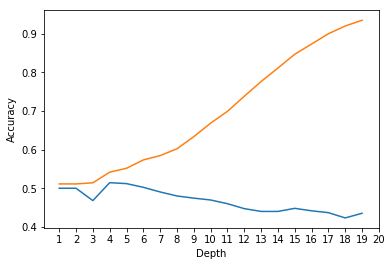

In [53]:
plt.plot([i[1] for i in accuracy_score_test], [i[0] for i in accuracy_score_test])
plt.plot([i[1] for i in accuracy_score_train], [i[0] for i in accuracy_score_train])
plt.xticks(range(1,21))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

As seen with the graph below with a depth of 4 the test set is on its best. After it it only gets worse and the training set will get better. This is overfitting.

In [54]:
accuracy_score_test = []
accuracy_score_train = []
for i in np.arange(0.05,0.40, 0.05):
    X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=i, random_state=33)
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(X_train, y_train)
    accuracy_score_test.append([metrics.accuracy_score(y_test, clf.predict(X_test)), 1 - i])
    accuracy_score_train.append([metrics.accuracy_score(y_train, clf.predict(X_train)), 1 - i])
    
print(accuracy_score_test)

[[0.532, 0.95], [0.49, 0.9], [0.4833555259653795, 0.85], [0.473, 0.8], [0.4712, 0.75], [0.472, 0.7], [0.47801256424900057, 0.6499999999999999]]


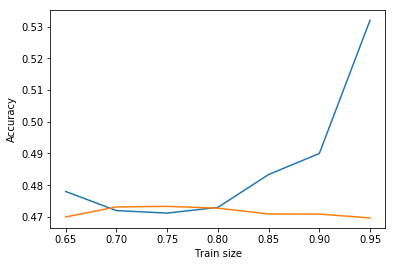

In [55]:
plt.plot([i[1] for i in accuracy_score_test], [i[0] for i in accuracy_score_test])
plt.plot([i[1] for i in accuracy_score_train], [i[0] for i in accuracy_score_train])
plt.ylabel('Accuracy')
plt.xlabel('Train size')
plt.show()

The test set around a size of 0.20 is fine. It has a good accuracy score for the training set and a good accuracy score for the test set.

### Random forest
The next step after decision trees is random forest. This combines multiple tree's to a forest.

In [56]:
matches_X = matches_custom[['rating_home','rating_away','previous_matches_home_wins',
                            'previous_matches_home_draws','previous_matches_home_losses','previous_matches_away_wins',
                            'previous_matches_away_draws','previous_matches_away_losses','previous_encounters_home_win',
                            'previous_encounters_home_draws','previous_encounters_home_losses']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

X_train.shape, y_train.shape

((3750, 11), (3750,))

In [57]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=10)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

[0.23512114 0.2324696  0.09535906 0.05351843 0.06736324 0.07900213
 0.05766938 0.06537545 0.03615548 0.04117069 0.03679539]


In [58]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.516


In [59]:
clf = RandomForestClassifier(n_estimators=8, max_depth=7)

scores = cross_val_score(clf, X_train, y_train, cv=5)
random_forest_all_param_score = np.average(scores)
random_forest_all_param_score

0.5226709617854135

With a depth of 10 and estimaters number of 10 we get an accuracy of 52% wich is a little bit better then the trees with 51% on the test set but the cross validation score is around 52% which is the same as the trees without parameter tuning. Next I will try if I get a better result with only the ratings of the teams.

In [60]:
matches_X = matches_custom[['rating_home','rating_away']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [61]:
clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [62]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.514


In [63]:
print(clf.feature_importances_)

[0.48042541 0.51957459]


The accuracy is less then with the other features on this one. This one has the same accuracy as the tree's with 51%.

Next I will plot a confusion matrix to show true and false predictions on wins, draws and losses.

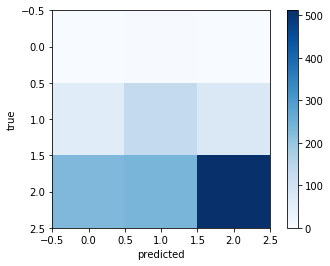

In [64]:
plt.imshow(metrics.confusion_matrix(y_pred, y_test), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');
plt.show()

In [65]:
print(Counter(y_pred).keys())
print(Counter(y_pred).values())
print(len(X_test))

dict_keys([2, 1, 0])
dict_values([980, 265, 5])
1250


As seen in the graph the algorithm predicts a lot of wins. This can be because a lot of home matches result in wins. Draws are a lot less predicted.

In [66]:
clf = RandomForestClassifier(n_estimators=15, max_depth=5)

scores = cross_val_score(clf, X_train, y_train, cv=5)
random_forest_rating_param_score = np.average(scores)
random_forest_rating_param_score

0.5472114441684933

The cross validation score however is a lot higher with less features. 

### Naive Bayes
Next I wanted to try to predict with naive bayes. Naive bayes has different version which can be used. I chose to use GaussianNB. Gaussian is used with continious data and normal distribution. Naive bayes works with probabilities.  

In [67]:
matches_X = matches_custom[['home_team','away_team','rating_home','rating_away','previous_matches_home_wins',
                            'previous_matches_home_draws','previous_matches_home_losses','previous_matches_away_wins',
                            'previous_matches_away_draws','previous_matches_away_losses','previous_encounters_home_win',
                            'previous_encounters_home_draws','previous_encounters_home_losses']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

X_train.shape, y_train.shape

((3750, 13), (3750,))

In [68]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

In [69]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.518


In [70]:
clf = GaussianNB()

scores = cross_val_score(clf, X_train, y_train, cv=5)
naive_bayes_all_param_score = np.average(scores)
naive_bayes_all_param_score

0.4930670094228315

In [71]:
matches_X = matches_custom[['home_team','away_team','rating_home','rating_away']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [72]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

In [73]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.481


In [74]:
clf = GaussianNB()

scores = cross_val_score(clf, X_train, y_train, cv=5)
naive_bayes_4_param_score = np.average(scores)
naive_bayes_4_param_score

0.48160886377872086

With naive bayes I can see that more features will improve the algorithm. With the many features the cross validation score is 0.49 and without it is 0.48. The results are less with this algorithm then the decision tree and random forest.

### Linear regression
I want to use linear regression to predict the chance for winning. The wins can have a linear relation to the outcome because if there are more previous wins the chance that the match will result in a win will be higher.

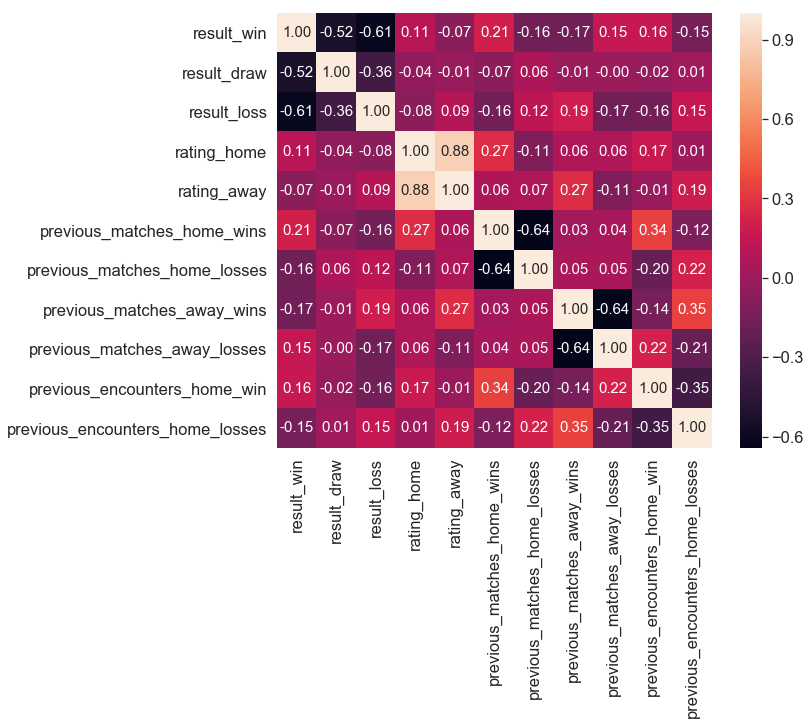

In [75]:
import seaborn as sns

df = matches_custom
df['result_win'] = df['result'] == 2
df['result_loss'] = df['result'] == 1
df['result_draw'] = df['result'] == 0
cols = ['result_win','result_draw','result_loss','rating_home','rating_away',
        'previous_matches_home_wins','previous_matches_home_losses',
        'previous_matches_away_wins','previous_matches_away_losses',
        'previous_encounters_home_win','previous_encounters_home_losses']

cm = np.corrcoef(df[cols].astype(float).values, rowvar=0)

plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols,
    xticklabels=cols)
plt.show()

As seen in the graph all variables have a correlation with the result the previous_matches_home_wins has the most influence.

In [76]:
matches_X = df[['rating_home','rating_away','previous_matches_home_wins','previous_matches_home_losses',
                'previous_matches_away_wins','previous_matches_away_losses','previous_encounters_home_win',
                'previous_encounters_home_losses']]
matches_y = matches_custom['result_win']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [77]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 0.003
Intercept: 0.423


In [78]:
y_pred = slr.predict(X_test)

In [79]:
print(y_pred)

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head(10)

[0.7591615  0.71547832 0.34319124 ... 0.53198211 0.11423903 0.47955959]


,Actual,Predicted
25822,1,0.759162
22862,0,0.715478
23635,0,0.343191
22850,1,0.660837
21771,1,0.462499
23647,0,0.357352
23813,1,0.477378
25842,0,0.446740
22590,0,0.363805
24929,0,0.637319


To check why the algorithm gives a chance of 71% to win the match with id 22862 I will inspect this row.

In [80]:
print(X_test.loc[22862])

rating_home                        931
rating_away                        868
previous_matches_home_wins          10
previous_matches_home_losses         0
previous_matches_away_wins           5
previous_matches_away_losses         4
previous_encounters_home_win         3
previous_encounters_home_losses      0
Name: 22862, dtype: object


With this information I also expect the home team to win. In soccer there is always a chance that the outcome is unpredictable.

In [81]:
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('R2 score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.4352657791742661
Mean Squared Error: 0.21965595139061825
R2 score: 0.11845142784677976


The R2 score in this case is of course very low this is because 1 and 0 are never predicted and the values are always in between. 

### Logistic Regression
Next I wanted to try logistic regression to get a classification instead of the chance.

In [82]:
matches_X = df[['rating_home','rating_away','previous_matches_home_wins','previous_matches_home_losses',
                'previous_matches_away_wins','previous_matches_away_losses','previous_encounters_home_win',
                'previous_encounters_home_losses']]
matches_y = matches_custom['result_win']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [83]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
y_pred = clf.predict(X_test)

In [85]:
print(y_pred)

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head(10)

[1 1 0 ... 1 0 0]


,Actual,Predicted
25822,1,1
22862,0,1
23635,0,0
22850,1,1
21771,1,0
23647,0,0
23813,1,0
25842,0,0
22590,0,0
24929,0,1


In [86]:
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.631


In [87]:
print(Counter(y_pred))

listOfItems = np.vstack((y_test.values, y_pred)).T.tolist()
setOfItems = []
newListOfItems = []
for item in listOfItems:
    if item in setOfItems:
        continue
    setOfItems.append(item)
    temp = list(item)
    occurence = listOfItems.count(item)
    temp.append(occurence)
    newListOfItems.append(temp)

print(newListOfItems)

Counter({0: 730, 1: 520})
[[1, 1, 324], [0, 1, 196], [0, 0, 465], [1, 0, 265]]


In [88]:
clf = LogisticRegression()

scores = cross_val_score(clf, X_train, y_train, cv=5)
logistic_regression_win_score = np.average(scores)
logistic_regression_win_score

0.6405333333333334

64% of the wins is predicted right which is considering it is a 50% chance of choosing the right one is a good result. Next I will try if predicting a loss is easier.

In [89]:
matches_X = df[['rating_home','rating_away','previous_matches_home_wins','previous_matches_home_losses',
                'previous_matches_away_wins','previous_matches_away_losses','previous_encounters_home_win',
                'previous_encounters_home_losses']]
matches_y = matches_custom['result_loss']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [90]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [91]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.714


In [92]:
print(Counter(y_pred))

listOfItems = np.vstack((y_test.values, y_pred)).T.tolist()
setOfItems = []
newListOfItems = []
for item in listOfItems:
    if item in setOfItems:
        continue
    setOfItems.append(item)
    temp = list(item)
    occurence = listOfItems.count(item)
    temp.append(occurence)
    newListOfItems.append(temp)

print(newListOfItems)

Counter({0: 1087, 1: 163})
[[0, 0, 804], [1, 0, 283], [0, 1, 75], [1, 1, 88]]


In [93]:
clf = LogisticRegression()

scores = cross_val_score(clf, X_train, y_train, cv=5)
logistic_regression_loss_score = np.average(scores)
logistic_regression_loss_score

0.7367999843555276

As seen above predicting the loss is easier then predicting the win. This is probably because there are a lot less losses in the home matches so the chance that the algorithm will predict a loss is a lot less high.

In [94]:
matches_X = df[['rating_home','rating_away','previous_matches_home_wins','previous_matches_home_losses',
                'previous_matches_away_wins','previous_matches_away_losses','previous_encounters_home_win',
                'previous_encounters_home_losses']]
matches_y = matches_custom['result_draw']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [95]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [96]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.768


In [97]:
print(Counter(y_pred))

listOfItems = np.vstack((y_test.values, y_pred)).T.tolist()
setOfItems = []
newListOfItems = []
for item in listOfItems:
    if item in setOfItems:
        continue
    setOfItems.append(item)
    temp = list(item)
    occurence = listOfItems.count(item)
    temp.append(occurence)
    newListOfItems.append(temp)

print(newListOfItems)

Counter({0: 1250})
[[0, 0, 960], [1, 0, 290]]


In [98]:
clf = LogisticRegression()

scores = cross_val_score(clf, X_train, y_train, cv=5)
logistic_regression_draw_score = np.average(scores)
logistic_regression_draw_score

0.7653337106969671

The draw is the easiest to predict. This could be because there are a lot less draws and the algorithm will almost never predict a draw.

### SVM
The last algorithm I wanted to try is SVM. SVM is mostly used for classification problems and tries to divide the different classifications with a hyper-plane.

In [99]:
matches_X = matches_custom[['rating_home','rating_away','previous_matches_home_wins','previous_matches_home_losses',
                'previous_matches_away_wins','previous_matches_away_losses','previous_encounters_home_win',
                'previous_encounters_home_losses']]
matches_y = matches_custom['result']
matches_y = matches_y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(matches_X, matches_y, test_size=0.25, random_state=33)

In [100]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [101]:
y_pred = clf.predict(X_test)
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy:0.538


In [102]:
np.unique(y_pred)

array([0, 1, 2])

The accuracy with SVM is also pretty good with 53%. The unique values show that the model does predict wins, draws and losses.

In [103]:
clf = svm.SVC(kernel='linear')

scores = cross_val_score(clf, X_train, y_train, cv=5)
svm_score = np.average(scores)
svm_score

0.5461319736864717

The cross validation shows that the score of this algorithm is 54% which is equal to the accuracy of the random forest with only the ratings.

### Conclusions

Predicting a win for the algorithm is a lot easier for the algorithm then predicting the actual outcome in loss, draw or win. This is logical because the chance for predicting a win right is already 50%. The outcome of logical regression on this one was 64%. The random forest with only the ratings had a better result than with all the variables. The accuracy with this was 54%. This was equal to the outcome of everything with SVM.

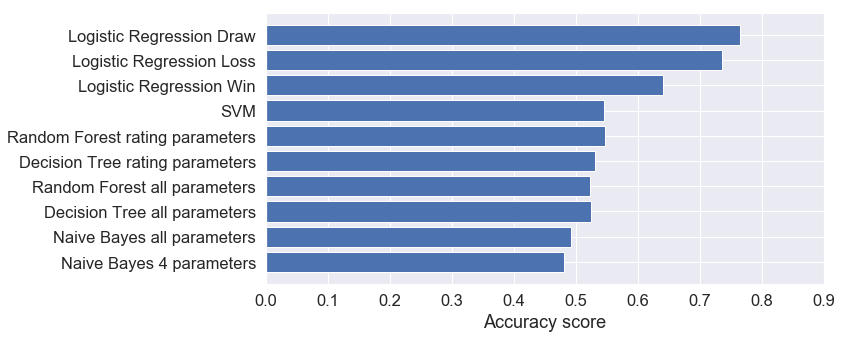

In [104]:
#Graph of all alogrithm scores compared.

fig, ax = plt.subplots(1,1,figsize=(10,5))
# Example data
algorithms = ('Logistic Regression Draw', 'Logistic Regression Loss', 'Logistic Regression Win', 'SVM',
              'Random Forest rating parameters', 'Decision Tree rating parameters', 'Random Forest all parameters', 
              'Decision Tree all parameters', 'Naive Bayes all parameters', 'Naive Bayes 4 parameters')
scores  = (logistic_regression_draw_score, logistic_regression_loss_score, logistic_regression_win_score, svm_score, 
           random_forest_rating_param_score, decision_tree_rating_param_score, random_forest_all_param_score,
           decision_tree_all_param_score, naive_bayes_all_param_score, naive_bayes_4_param_score)


y_pos = np.arange(len(algorithms))

ax.barh(y_pos, scores, align='center')
ax.set_xticks(np.arange(0, 1, step=0.1))
ax.set_yticks(y_pos)
ax.set_yticklabels(algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy score')

plt.show()